# 1.7c: Logit Distinguishability Test

This notebook tests whether cluster tokens are distinguishable from each other in logit space.

## The Question

We've found 2,212 tokens geometrically packed into a tiny volume. **Can the model distinguish between them?**

During generation, the model:
1. Produces a hidden state vector **h**
2. Computes **logits = W @ h** (dot product with each token embedding)
3. Applies softmax and samples

**If cluster tokens have identical embeddings, they'll get identical logits for any h.**

## The Experiment

We'll compute logits using h = PC1 (maximum variance direction) and compare three distributions:

1. **All tokens (151,936):** Should show normal variation (S-curve)
2. **Random sample (2,212 non-cluster tokens):** Should show same variation as full set
3. **Cluster tokens (2,212):** Should show degeneracy (flat line if embeddings are identical)

## Method

1. Load W in **bfloat16** (this is how the model actually runs)
2. Load PC1 from cluster reference frame
3. Compute logits = W @ h in bfloat16
4. Create three plots to compare distributions
5. Measure logit variation in each distribution

## Parameters

In [14]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Random seed for reproducibility
RANDOM_SEED = 42

# Visualization
FIGSIZE = (18, 5)
DPI = 150

## Imports

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

# Set random seed
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Device Detection

In [16]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Unembedding Matrix (bfloat16)

In [17]:
# Load W in bfloat16 (as the model actually uses it)
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W = load_file(tensor_path)["W"].to(device)
N, d = W.shape

print(f"Loaded W: {W.shape}")
print(f"  {N:,} tokens in {d:,} dimensions")
print(f"  dtype: {W.dtype}")

Loaded W: torch.Size([151936, 2560])
  151,936 tokens in 2,560 dimensions
  dtype: torch.bfloat16


## Load Cluster Reference Frame (PC1)

In [18]:
# Load precomputed PCA from 1.6a
ref_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_reference_frame.safetensors")
ref_data = load_file(ref_path)
eigenvectors = ref_data['W_eigenvectors'].to(device)

# Extract PC1
pc1 = eigenvectors[:, 0]

# Convert to bfloat16 to match W
pc1 = pc1.to(W.dtype)

print(f"\nLoaded cluster reference frame")
print(f"  PC1 shape: {pc1.shape}")
print(f"  PC1 dtype: {pc1.dtype}")
print(f"  PC1 norm: {torch.linalg.vector_norm(pc1.float()).item():.6f}")


Loaded cluster reference frame
  PC1 shape: torch.Size([2560])
  PC1 dtype: torch.bfloat16
  PC1 norm: 1.000067


## Load Cluster Tokens

In [19]:
# Load cluster tokens from 1.4h
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.4h_cluster_tokens.safetensors")
cluster_data = load_file(cluster_path)
cluster_token_ids = cluster_data['cluster_token_ids'].to(device)

print(f"\nLoaded {len(cluster_token_ids):,} cluster token IDs")
print(f"  Token ID range: [{cluster_token_ids.min().item()}, {cluster_token_ids.max().item()}]")


Loaded 2,212 cluster token IDs
  Token ID range: [124, 151935]


## Compute Logits (bfloat16)

In [20]:
print(f"\n{'='*70}")
print("COMPUTING LOGITS IN BFLOAT16")
print(f"{'='*70}\n")

# Use PC1 as query direction
h = pc1

print(f"Query vector: PC1")
print(f"  Shape: {h.shape}")
print(f"  dtype: {h.dtype}")

# Compute logits: dot product with all tokens
print(f"\nComputing logits = W @ h...")
logits = W @ h
print(f"✓ Logits computed: {logits.shape}")
print(f"  dtype: {logits.dtype}")

# Convert to float32 for statistics (but keep bfloat16 values)
logits_f32 = logits.float()

# Statistics for all tokens
print(f"\nLogit distribution (all {N:,} tokens):")
print(f"  Max: {logits_f32.max().item():.10f}")
print(f"  Min: {logits_f32.min().item():.10f}")
print(f"  Mean: {logits_f32.mean().item():.10f}")
print(f"  Median: {logits_f32.median().item():.10f}")
print(f"  Std: {logits_f32.std().item():.10f}")
print(f"  Range: {(logits_f32.max() - logits_f32.min()).item():.10f}")


COMPUTING LOGITS IN BFLOAT16

Query vector: PC1
  Shape: torch.Size([2560])
  dtype: torch.bfloat16

Computing logits = W @ h...
✓ Logits computed: torch.Size([151936])
  dtype: torch.bfloat16

Logit distribution (all 151,936 tokens):
  Max: 0.7265625000
  Min: -0.8046875000
  Mean: 0.2595545352
  Median: 0.2812500000
  Std: 0.1024190858
  Range: 1.5312500000


## Sample Random Non-Cluster Tokens

In [21]:
print(f"\n{'='*70}")
print("SAMPLING RANDOM NON-CLUSTER TOKENS")
print(f"{'='*70}\n")

# Create mask for non-cluster tokens
all_token_ids = torch.arange(N, device=device)
cluster_mask = torch.isin(all_token_ids, cluster_token_ids)
non_cluster_token_ids = all_token_ids[~cluster_mask]

print(f"Non-cluster tokens: {len(non_cluster_token_ids):,}")

# Randomly sample 2,212 tokens from non-cluster
sample_size = len(cluster_token_ids)
random_indices = torch.randperm(len(non_cluster_token_ids), device=device)[:sample_size]
random_sample_ids = non_cluster_token_ids[random_indices]

print(f"Random sample size: {len(random_sample_ids):,}")
print(f"  Token ID range: [{random_sample_ids.min().item()}, {random_sample_ids.max().item()}]")


SAMPLING RANDOM NON-CLUSTER TOKENS

Non-cluster tokens: 149,724
Random sample size: 2,212
  Token ID range: [61, 151564]


## Extract Logit Distributions

In [22]:
# Extract logits for each distribution
cluster_logits = logits[cluster_token_ids].float()
random_logits = logits[random_sample_ids].float()

# Sort for plotting
all_logits_sorted = torch.sort(logits_f32, descending=True)[0].cpu().numpy()
cluster_logits_sorted = torch.sort(cluster_logits, descending=True)[0].cpu().numpy()
random_logits_sorted = torch.sort(random_logits, descending=True)[0].cpu().numpy()

print(f"\n{'='*70}")
print("LOGIT DISTRIBUTION STATISTICS")
print(f"{'='*70}\n")

print(f"Cluster tokens ({len(cluster_logits):,} tokens):")
print(f"  Max: {cluster_logits.max().item():.10f}")
print(f"  Min: {cluster_logits.min().item():.10f}")
print(f"  Mean: {cluster_logits.mean().item():.10f}")
print(f"  Std: {cluster_logits.std().item():.10f}")
print(f"  Range: {(cluster_logits.max() - cluster_logits.min()).item():.10f}")

print(f"\nRandom sample ({len(random_logits):,} tokens):")
print(f"  Max: {random_logits.max().item():.10f}")
print(f"  Min: {random_logits.min().item():.10f}")
print(f"  Mean: {random_logits.mean().item():.10f}")
print(f"  Std: {random_logits.std().item():.10f}")
print(f"  Range: {(random_logits.max() - random_logits.min()).item():.10f}")


LOGIT DISTRIBUTION STATISTICS

Cluster tokens (2,212 tokens):
  Max: 0.3085937500
  Min: 0.3085937500
  Mean: 0.3085937500
  Std: 0.0000000000
  Range: 0.0000000000

Random sample (2,212 tokens):
  Max: 0.5273437500
  Min: -0.3007812500
  Mean: 0.2607313097
  Std: 0.0995435342
  Range: 0.8281250000


## Visualization: Three-Way Comparison


Creating three-way comparison plots...



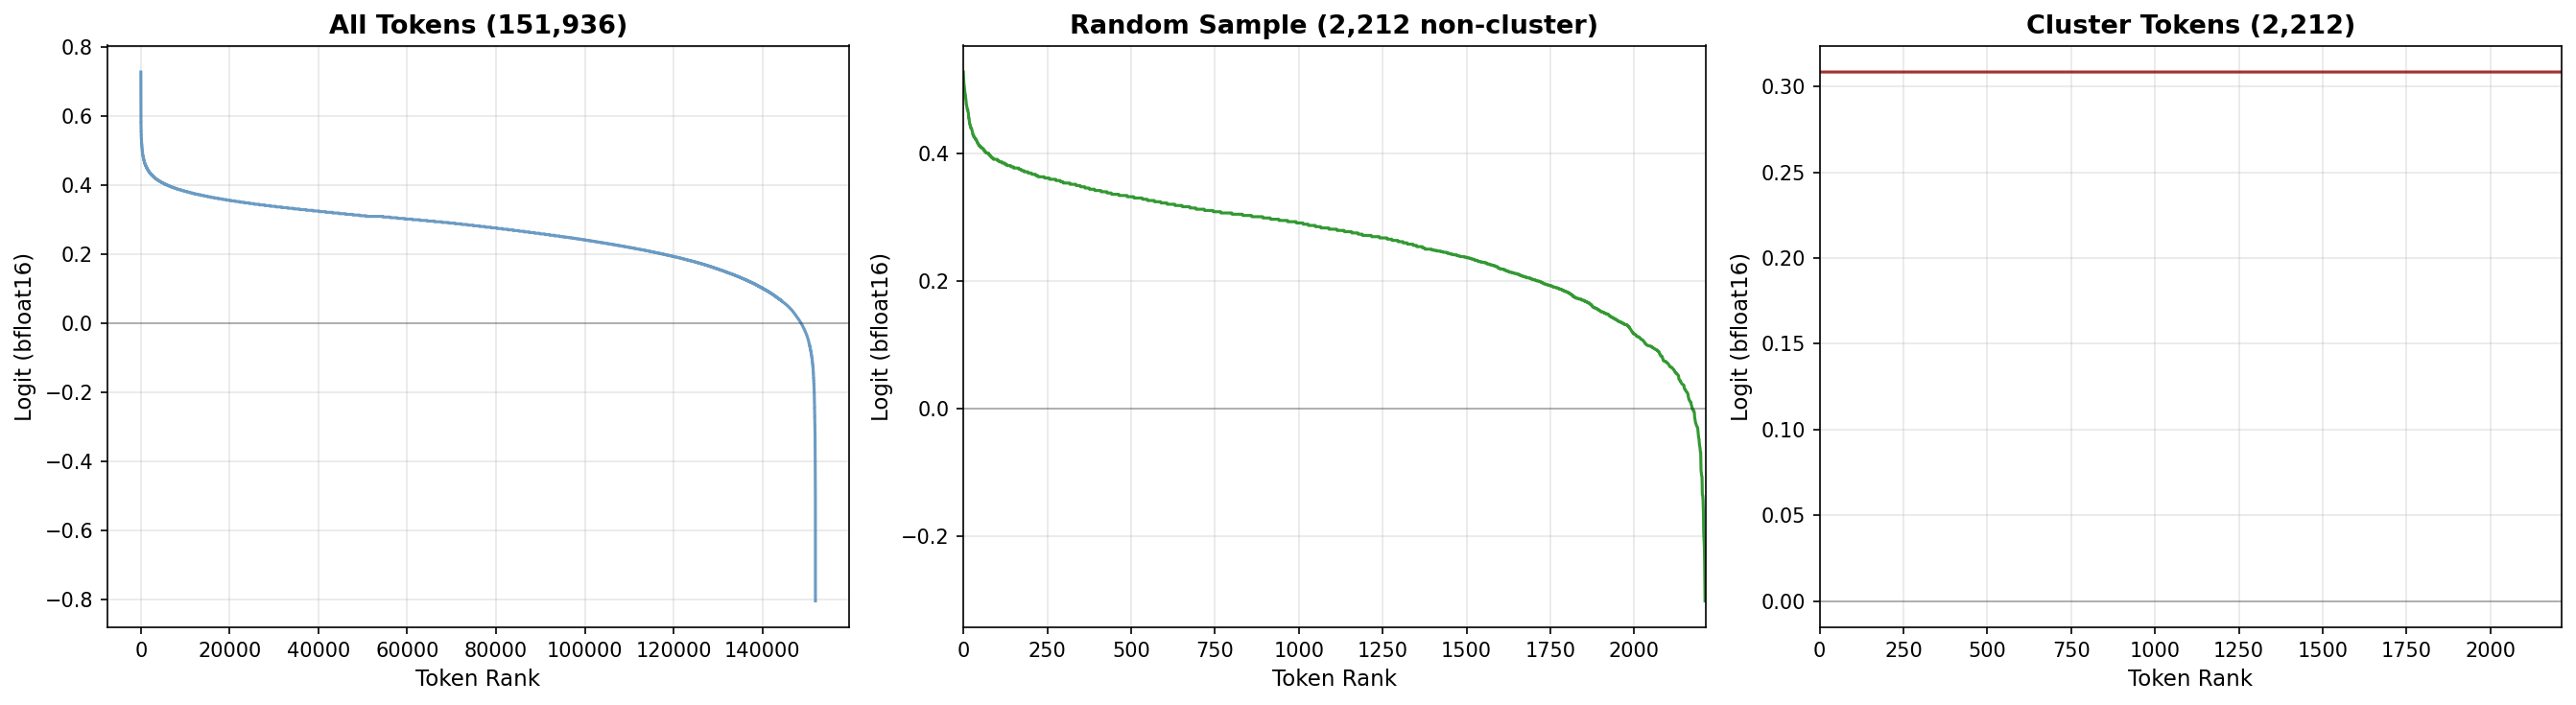

✓ Three-way comparison complete


In [23]:
print(f"\nCreating three-way comparison plots...\n")

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=FIGSIZE, dpi=DPI)

# Plot 1: All tokens (151,936)
ax1.plot(all_logits_sorted, linewidth=1.5, color='steelblue', alpha=0.8)
ax1.set_xlabel('Token Rank', fontsize=11)
ax1.set_ylabel('Logit (bfloat16)', fontsize=11)
ax1.set_title(f'All Tokens ({N:,})', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)

# Plot 2: Random sample (2,212 non-cluster tokens)
ax2.plot(random_logits_sorted, linewidth=1.5, color='green', alpha=0.8)
ax2.set_xlabel('Token Rank', fontsize=11)
ax2.set_ylabel('Logit (bfloat16)', fontsize=11)
ax2.set_title(f'Random Sample ({len(random_logits):,} non-cluster)', fontsize=13, fontweight='bold')
ax2.set_xlim(0, len(random_logits_sorted))
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)

# Plot 3: Cluster tokens (2,212)
ax3.plot(cluster_logits_sorted, linewidth=1.5, color='darkred', alpha=0.8)
ax3.set_xlabel('Token Rank', fontsize=11)
ax3.set_ylabel('Logit (bfloat16)', fontsize=11)
ax3.set_title(f'Cluster Tokens ({len(cluster_logits):,})', fontsize=13, fontweight='bold')
ax3.set_xlim(0, len(cluster_logits_sorted))
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Three-way comparison complete")

## Summary

This experiment tests distinguishability by comparing logit distributions.

**Expected Results:**

1. **All tokens:** S-curve (sigmoid-ish) showing normal variation
   - High logits for tokens aligned with PC1
   - Low logits for tokens anti-aligned with PC1
   - Smooth gradient between extremes

2. **Random sample:** Same S-curve shape
   - Proves the shape is characteristic of normal vocabulary
   - Sample size doesn't change the distribution pattern

3. **Cluster tokens:** Flat horizontal line
   - All tokens get identical (or near-identical) logits
   - Proves geometric degeneracy → functional indistinguishability

**Interpretation:**

- **If plots 1 & 2 show S-curves and plot 3 is flat:** Cluster is degenerate, model cannot distinguish these tokens
- **If all three plots show S-curves:** Cluster has normal variation, tokens are distinguishable

**Key metrics:**
- Logit range: difference between max and min
- Logit std dev: measure of variation
- Visual shape: smooth curve vs flat line